<a href="https://colab.research.google.com/github/tusharpoddar/e-Science-Research/blob/master/GoogleDrive/Interpolated_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The following file shows how to use the spectorgrams made using the scipy function with the VGGish model. 

The data in the NetCDF file(that stores the data of the spectrograms made using the scipy functions) is of the form (26666, 55, 257). Where 55 represents the time stamps and 257 represents the frequency stamps. In order for this data to be used by the VGGish model we need to convert it in the form of (?, 96, 64). Where 96 represent the time stamps and 64 represents the frequency stamps. This notebook explains how to convert the data from the netCDF format to the numpy format so that it can be used by the VGGish model.

### Things this file can do - 
Just specify the name of the wav file that needs to be converted to the spectrogram data and this will give you the numpy array in the shape that can be fed to the VGG model. 

In [ ]:
# the following code is done in order to compare the spectrograms that we get from the vggish and the ones that we directly get from the function 
# scipy spectrogram. 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
import matplotlib.pyplot as plt

from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats

In [ ]:
def create_slice_from_wav(file_path, file_len, slice_len, step_size):
  """Creates small slices from wav file. file_length is desired length of file in minutes.
  slice_len is desired legth of each slice in ms. 
  step_size is how big of step to take between steps (larger size is less overlap)."""
  
  #read in wav file
  samp_freq, sig_data = wavfile.read(file_path)
  
  #convert file_length from min to sample numbers
  file_length_num = 5*samp_freq*60
  
  #convert slice_len from ms to sample numbers
  slice_sample_num = slice_len*samp_freq/1000
  
  #use only slices within file_length
  sig_data = sig_data[0:int(file_length_num)]
  
  #determine number of samples and length
  n_samples = sig_data.shape[0]
  sig_len = n_samples/samp_freq
  print('Length: ' + str(sig_len) + ' sec')
  
  #create slices 
  steps = int(slice_sample_num*step_size)
  slices = util.view_as_windows(sig_data, window_shape=(slice_sample_num,), step=steps)
  print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
  
  return samp_freq, sig_data, slices, steps, sig_len

def create_spec_from_slice_array(slices, steps, spec_window, NFFT, samp_freq):
  """Creates fft spectrogram from slice. spec_window is length of each segment (nperseg).
  NFFT is length of the FFT used (nfft). samp_freq is sampling frequency (in Hz) of slice (fs).
  steps is step size between slices"""
  
  spec_slices = {}
  samp_freq_kHz = samp_freq/1000

  for i in range(slices.shape[0]): 
    #spectrogram
    freqs_spec, times, Sx = signal.spectrogram(slices[i,:], fs=samp_freq, nperseg = spec_window, nfft = NFFT, mode =  'magnitude')

    time_stamp = ((i*steps) / samp_freq_kHz)

    #store as dic
    spec_slices[time_stamp] = Sx

  return spec_slices, freqs_spec, times

# to be called just one, we will do the sorting again and again
def make_git_spectrogram():
  # Make a waveform for each class.
  #num_seconds = 0.0225
  file_len=5
  slice_len=25
  step_size=0.9

  spec_window=128
  NFFT=512

  path = '/content/gdrive/Shared drives/Research/Data/Wav Files/input5mins.wav'

  #create slices

  samp_freq, sig_data, slices, steps, sig_len = create_slice_from_wav(path, file_len, slice_len, step_size)
  #print(str('Slices created in ' + str(end - start) + '  seconds'))

  #create spectrograms
  spec_slices, freqs_spec, times = create_spec_from_slice_array(slices, steps, spec_window, NFFT, samp_freq)
  #print(str('Spectrograms created in ' + str(end - start) + '  seconds'))
  # once we have the dictonary we need to calculate the numpy array
  plotting_data = []
  for temp in spec_slices:
    plotting_data.append(spec_slices[temp].T)
  
  arr = np.array(plotting_data) 
  arrShape = arr.shape
  git_Spectrogram = np.reshape(arr, (arrShape[0]*arrShape[1], arrShape[2]))
  print(git_Spectrogram.shape)
  print(arrShape)
  return git_Spectrogram, arr

In [ ]:
gitSpectrogram, threedarr = make_git_spectrogram()

Length: 300.0 sec
Audio shape: (75000000,), Sliced audio shape: (13333, 6250)
(733315, 257)
(13333, 55, 257)


In [ ]:
# working with the 3darray that i get from running the above function 
array = np.array(threedarr)
newArr = []
array.shape
for temp in array:
  changed = cv2.resize(temp, (64, 96))
  newArr.append(changed)
changed = np.array(newArr)

In [ ]:
changed.shape

(13333, 96, 64)

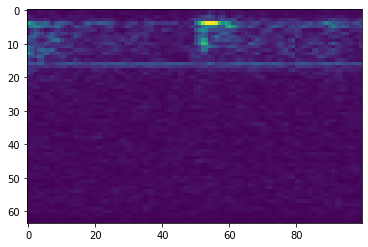

In [ ]:
# cheching if the thing made is correct
ploter = np.reshape(changed, (13333*96, 64))
ploter = ploter.T
plt.imshow(ploter[:, 400:500])

In [ ]:
gitSpectrogram.shape

(733315, 257)

In [ ]:
# now forr some time we need to calculate the window that we want to select
gitSpectrogram = gitSpectrogram.T

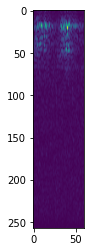

In [ ]:
time = 12
windowTimeGit = int(gitSpectrogram.shape[1]*time / 300)
plt.imshow(gitSpectrogram[:, windowTimeGit - 30:windowTimeGit + 30])
temp = gitSpectrogram[:, windowTimeGit - 30:windowTimeGit + 30]

In [ ]:
temp.shape

(257, 60)

In [ ]:
temp = temp.T

In [ ]:
temp.shape

(60, 257)

In [ ]:
# we now need to change it to 96 * 64 kind of a thing
# so we need to have 96 time bind and 
import cv2

In [ ]:
changed = cv2.resize(temp, (64, 96))

In [ ]:
changed.shape

(96, 64)

In [ ]:
newArr = []
newArr.append(changed)

In [ ]:
FinalArr = np.array(newArr)

In [ ]:
FinalArr.shape

(1, 96, 64)

In [ ]:
newArr = []
newArr.append(changed)

In [ ]:
arr = np.array(newArr)

In [ ]:
arr.shape

(1, 64, 96)

In [ ]:
# making a function that produces the array that that specific time
def spectrogramMaker(time, gitSpectrogram):
  gitSpectrogram = gitSpectrogram.T
  time = 12
  windowTimeGit = int(gitSpectrogram.shape[1]*time / 300)
  temp = gitSpectrogram[:, windowTimeGit - 30:windowTimeGit + 30]
  temp = temp.T
  changed = cv2.resize(temp, (64, 96))
  newArr = []
  newArr.append(changed)
  FinalArr = np.array(newArr)
  return FinalArr

In [ ]:
times = [52.36087475, 56.13919295, 121.0993401, 121.1951882, 222.3025125, 121.5241679]

In [ ]:
temp1 = spectrogramMaker(52.36087475, np.copy(gitSpectrogram))

In [ ]:
temp2 = spectrogramMaker(56.13919295, np.copy(gitSpectrogram))

In [ ]:
all_examples = np.concatenate((temp1, temp2))

In [ ]:
all_examples.shape

(2, 96, 64)

In [ ]:
allSpectrogram = []

In [ ]:
for time in times:
  temp = spectrogramMaker(time, np.copy(gitSpectrogram))
  allSpectrogram.append(temp)

In [ ]:
all_examples= np.array([], dtype=np.float64)

In [ ]:
all_examples = np.concatenate((allSpectrogram))

In [ ]:
all_examples.shape

(6, 96, 64)